# Setup and utility functions

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os import path

%matplotlib inline

from neo4j.v1 import GraphDatabase

sns.set_context("paper", font_scale=1.8)

In [6]:
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "1234"))

In [7]:
def run_query(string):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            return tx.run(string)

In [8]:
def save_table(filename, table, caption='', label=''):
    with open(filename, 'w') as file:
        if caption:
            caption = "\\caption{%s}\n" % caption
        if label:
            label = "\\label{%s}\n" % label
        cont = (
            "\\begin{table}\n"
            "\\centering\n"
        ) + table + caption + label + (
            "\\end{table}"
        ) 
        file.write(cont)

In [9]:
def print_figure_inclusion(filename, plot, caption='', label=''):
    img_figure = path.splitext(path.basename(filename))[0] + '.pdf'
    if caption:
        caption = "\\caption{%s}\n" % caption
    if label:
        label = "\\label{%s}\n" % label
    cont = (
        "\\begin{figure}\n"
        "\\centering\n"
        "\\includegraphics[width=\\linewidth]{data/figures/%s}\n" % img_figure
    )  + caption + label + (
        "\\end{figure}"
    ) 
    print(cont)

# Included authors

In [10]:
author_names = [t[0] for t in run_query('MATCH (n:Author) where not n.name = "Aristotle" RETURN n.name ORDER BY n.name asc').values()]

# Relation between determination and all positive doctrines

The following two measing (1) only determination doctrines, i.e. first level doctrines supporting the possibility of the science, and (2) all positive doctrines, i.e. all doctrines that do not directly attack the possibility of a science. This means that the second group of positive doctrines also includes points at further removes from the primary level of determination doctrines, and it will also include doctrine that can be used to refute rationes principales. It does however not include doctrines that are *only* used to refute rationes.

## Observation

The greater amount of data on the use of all positive doctrines seems to present a more nuanced and clear picture.

# Direct determination doctrines

## Some general quantities

In [11]:
def count_unique_determination_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT (:Question)--(d)--(q:Question)"
         "RETURN count(distinct d)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_determination_doctrines('John of Jandun')

0

In [12]:
def count_shared_determination_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s' and not(a.name = 'Aristotle')"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_determination_doctrines('John of Jandun')

2

Proportion unique of all doctrines

In [13]:
def unique_to_shared_proportion(name):
    unique = count_unique_determination_doctrines(name)
    shared = count_shared_determination_doctrines(name)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun')

0.0

Now let's get the values of these for all the commentators and put them into a matrix.

In [14]:
def unique_shared_determinations_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_determination_doctrines(a)
        shared = count_shared_determination_doctrines(a)
        prop = unique_to_shared_proportion(a)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_determinations_all(author_names)

Put this in a DataFrame and sort according to most unique.

In [15]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Sum', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].apply(np.int64)
df

,Unique,Shared,Sum,Proportion
Anonymus Mertoniensis 275,0,6,6,0.00
Anonymus Bernardini,1,4,5,0.20
Anonymus Vat. Lat. 2170 I,1,4,5,0.20
Anonymus Oriel 33,0,3,3,0.00
Anonymus Vennebusch,0,3,3,0.00
Henric de la Wyle,1,2,3,0.33
John Dinsdale,0,3,3,0.00
Radulphus Brito,0,3,3,0.00
Simon of Faversham,0,3,3,0.00
Anonymus Steenberghen,1,1,2,0.50


In [16]:
# Some saving could be set up here...
save_table('../thesis/data/tables/sci-determinations-quantities.tex', df.to_latex(), 
           caption='Unique, shared, total, and proportion of unique to shared doctrines in determinations.',
           label='tab:sci:determ:quantities')

In [17]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     4
Shared    37
Sum       41
dtype: int64

In [18]:
# Number of distinct rationes
doctrine_count = run_query('MATCH (d:Doctrine)'
                           'WHERE (d)-[:SUPPORTS]->(:Doctrine {name:"There can be a science of the soul"})'
                           'AND NOT d.name="There can be a science of the soul"'
                           'RETURN count(DISTINCT d)').single()[0]
doctrine_count

11

In [19]:
# Proportion of unique
df['Unique'].sum() / doctrine_count

0.36363636363636365

In [20]:
# Proportion of unique instances
df['Unique'].sum() / df['Sum'].sum()

0.0975609756097561

In [21]:
# Average use number of non-uniques
round(df['Sum'].sum() / (doctrine_count - df['Unique'].sum()), 1)

5.9

## Proportional distribution matrix

In [22]:
def number_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q:Question)--(d)--(:Question)--(:Text)--(a2:Author)"
                         "WHERE a.name = {name}"
                         "RETURN a2.name, count(distinct d)", name=name)
            return {r[0]: r[1] for r in res}

number_shared_determination_doctrines('Anonymus Giele')

{'Anonymus Bernardini': 1,
 'Anonymus Mertoniensis 275': 1,
 'Anonymus Oriel 33': 1,
 'Anonymus Vat. Lat. 2170 I': 1,
 'Anonymus Vennebusch': 1,
 'John Dinsdale': 1,
 'John of Jandun': 1,
 'Radulphus Brito': 1,
 'Simon of Faversham': 1}

In [23]:
def proportion_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q1:Question)--(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (q1:Question)--(d1:Doctrine) WHERE (d1)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "MATCH (q2:Question)--(d2:Doctrine) WHERE (d2)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Bernardini': 0.26666666666666666,
 'Anonymus Giele': 0.3333333333333333,
 'Anonymus Mertoniensis 275': 0.5,
 'Anonymus Oriel 33': 1.0,
 'Anonymus Vat. Lat. 2170 I': 0.26666666666666666,
 'Anonymus Vat. Lat. 2170 II': 0.3333333333333333,
 'Anonymus Vennebusch': 0.4444444444444444,
 'Henric de la Wyle': 0.4444444444444444,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.6666666666666666,
 'Radulphus Brito': 0.4444444444444444,
 'Simon of Faversham': 0.4444444444444444}

In [24]:
author_names

['Anonymus Bazan I',
 'Anonymus Bernardini',
 'Anonymus Giele',
 'Anonymus Mertoniensis 275',
 'Anonymus Oriel 33',
 'Anonymus Steenberghen',
 'Anonymus Vat. Lat. 2170 I',
 'Anonymus Vat. Lat. 2170 II',
 'Anonymus Vennebusch',
 'Henric de la Wyle',
 'John Dinsdale',
 'John of Jandun',
 'Radulphus Brito',
 'Simon of Faversham']

In [25]:

def build_matrix(authors, docfunc=proportion_shared_determination_doctrines):
    matrix = {}
    for author in authors:
        matrix[author] = []
        values = docfunc(author)
        for name in authors:
            if name in values:
                matrix[author].append(values[name])
            else:
                matrix[author].append(0)
    return matrix

d = build_matrix(author_names)
            

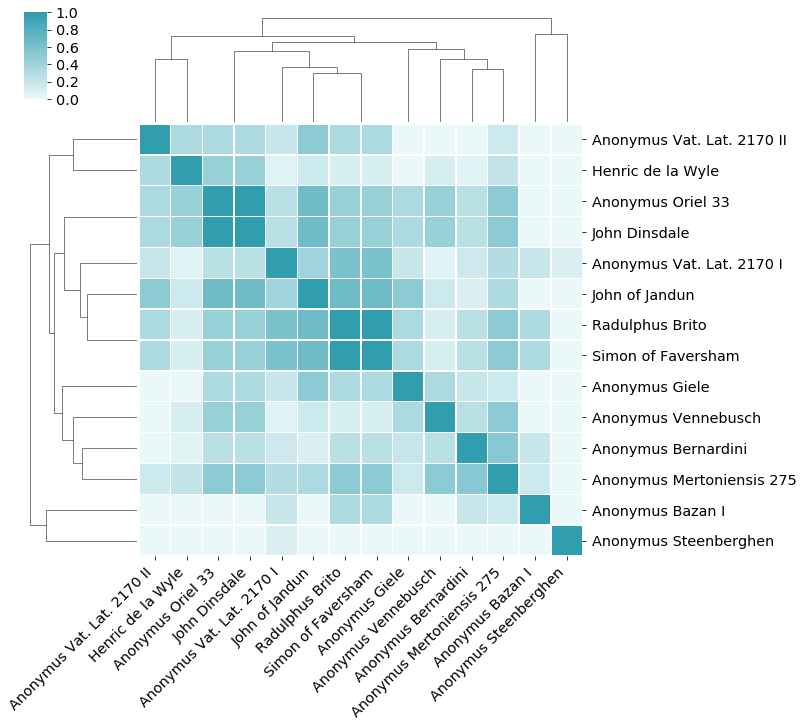

In [26]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [27]:
plot.savefig('../thesis/data/figures/science-determ-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-determ-proportional-clustermap', plot,
    caption='Proportional clustermap of determination doctrines.',
    label='fig:sci:determ:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-determ-proportional-clustermap.pdf}
\caption{Proportional clustermap of determination doctrines.}
\label{fig:sci:determ:prop-clustermap}
\end{figure}


In [28]:
# Mean commonality values 
df.mean().sort_values(ascending=False).round(1)

John Dinsdale                 0.4
Anonymus Oriel 33             0.4
Simon of Faversham            0.4
Radulphus Brito               0.4
John of Jandun                0.4
Anonymus Mertoniensis 275     0.4
Anonymus Vat. Lat. 2170 I     0.3
Anonymus Giele                0.3
Anonymus Bernardini           0.3
Anonymus Vennebusch           0.3
Anonymus Vat. Lat. 2170 II    0.3
Henric de la Wyle             0.2
Anonymus Bazan I              0.2
Anonymus Steenberghen         0.1
dtype: float64

In [29]:
# Dinsdale example
dins = df['John Dinsdale'].round(decimals=2)
save_table('../thesis/data/tables/dinsdale-fingerprint.tex', dins.to_latex(), 
           caption='Example of proportional shared profile for determination doctrines of John Dinsdale.',
           label='tab:sci:determ:profile-dinsdale')
dins

Anonymus Bazan I              0.00
Anonymus Bernardini           0.27
Anonymus Giele                0.33
Anonymus Mertoniensis 275     0.50
Anonymus Oriel 33             1.00
Anonymus Steenberghen         0.00
Anonymus Vat. Lat. 2170 I     0.27
Anonymus Vat. Lat. 2170 II    0.33
Anonymus Vennebusch           0.44
Henric de la Wyle             0.44
John Dinsdale                 1.00
John of Jandun                0.67
Radulphus Brito               0.44
Simon of Faversham            0.44
Name: John Dinsdale, dtype: float64

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

In [30]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author)--(t:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "RETURN d.name" % name )
    return [t[0] for t in run_query(q).values()]

# Example test
determination_doctrines_of("Anonymus Giele")

['Substantial knowledge from accidents']

Then we create a full list of all the doctrines in determinations.

In [31]:
def all_determination_doctrines():
    q = ("MATCH (d:Doctrine)--(:Question)"
         "WHERE (d)-[:SUPPORTS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT d.name = 'There can be a science of the soul'"
         "RETURN distinct d.name ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_determination_doctrines()

# Test output
all_docs

['Certain science about simple subject',
 'Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)',
 'Identity of knower and known',
 'Propter quod unumquodque tale et illud magis',
 'Science about a substance which contains parts and properties',
 'Science of form and perfection',
 'Science through self-reflection',
 'Science through subject, properties, principles',
 'Soul indirectly available to sense perception',
 'Substantial knowledge from accidents',
 'There can be science about everything with intelligible essence or definition']

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [32]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


df = pd.DataFrame(matrix, index=all_docs)

Okay, I want to sort the matrix by how many doctrines the texts contain. This means that we sort the columns based on the sum of the values. Oddly enough I can't figure out how to do that within the `DataFrame`, so instead I create a dict, from that a list of the authors sorted by their sum doctrines. That list is used for keys in building a new matrix with the desired order. But then the rows and columns are switched, so I need to transmute those with the `zip` function. *This just doesn't feel right*.

In [33]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = determination_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

,Anonymus Bernardini,Anonymus Steenberghen,Anonymus Mertoniensis 275,Anonymus Vennebusch,Anonymus Vat. Lat. 2170 I,Henric de la Wyle,Radulphus Brito,Simon of Faversham,Anonymus Bazan I,Anonymus Oriel 33,John Dinsdale,John of Jandun,Anonymus Vat. Lat. 2170 II,Anonymus Giele
Certain science about simple subject,x,,,,,,,,,,,,,
"Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)",,x,,,,,,,,,,,,
Identity of knower and known,x,,x,,,,,,,,,,,
Propter quod unumquodque tale et illud magis,,,x,x,,,,,,,,,,
Science about a substance which contains parts and properties,,x,,,x,,,,,,,,,
Science of form and perfection,,,,,,x,,,,,,,,
Science through self-reflection,x,,x,,x,,x,x,x,,,,,
"Science through subject, properties, principles",,,x,,x,x,x,x,,x,x,x,x,
Soul indirectly available to sense perception,x,,x,x,,x,,,,x,x,,,
Substantial knowledge from accidents,x,,x,x,x,,x,x,,x,x,x,,x


I can sort the sum of the DataFrame like this, but I can't figure out how to sort the columns by that.

In [34]:

df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums

Anonymus Mertoniensis 275     6
Anonymus Vat. Lat. 2170 I     5
Anonymus Bernardini           5
John Dinsdale                 3
Anonymus Oriel 33             3
Simon of Faversham            3
Radulphus Brito               3
Henric de la Wyle             3
Anonymus Vennebusch           3
John of Jandun                2
Anonymus Steenberghen         2
Anonymus Giele                1
Anonymus Vat. Lat. 2170 II    1
Anonymus Bazan I              1
dtype: int64

In [35]:
#print(sums.to_latex())

What is the mean amount of doctrines?

In [36]:
df.sum().mean()

2.9285714285714284

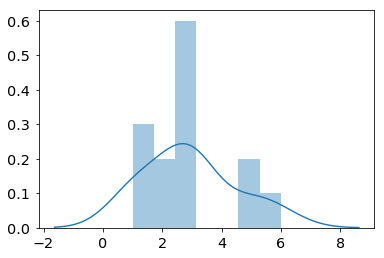

In [37]:
sns.distplot(df.sum())

### Popularity of arguments

In [38]:
df.sum(axis=1).sort_values(ascending=False)

Substantial knowledge from accidents                                                                       10
Science through subject, properties, principles                                                             9
Soul indirectly available to sense perception                                                               6
Science through self-reflection                                                                             6
Science about a substance which contains parts and properties                                               2
Propter quod unumquodque tale et illud magis                                                                2
Identity of knower and known                                                                                2
There can be science about everything with intelligible essence or definition                               1
Science of form and perfection                                                                              1
Four requi

# Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

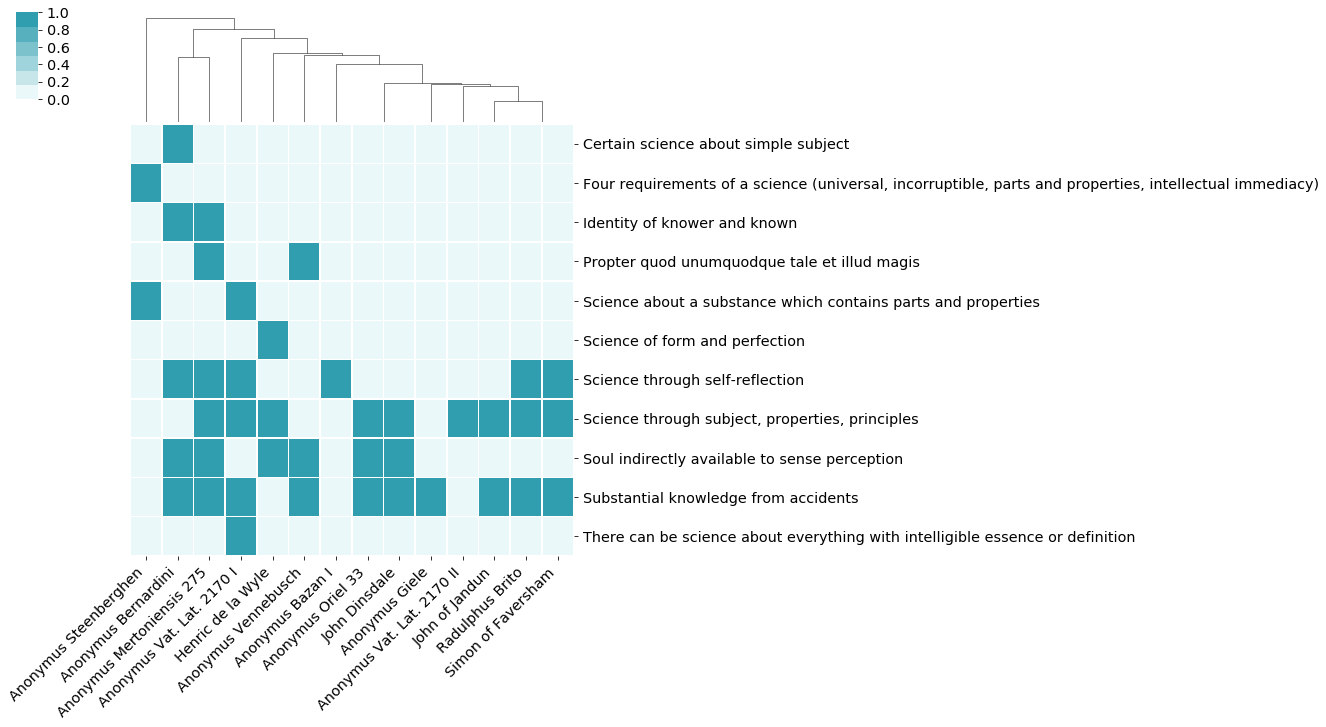

In [39]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=False, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

# Positive doctrines (determinations and rationes)

In [40]:
def count_unique_positive_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND NOT (:Question)--(d)--(q:Question)"
         "RETURN count(distinct d)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_unique_positive_doctrines('John of Jandun')

2

In [41]:
def count_shared_positive_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s' and not(a.name = 'Aristotle')"
         "AND NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "MATCH (q1:Question)--(d)"
         "WHERE (q1) <> (q)"
         "RETURN count(distinct d), collect(distinct d.name)" % (name))
    try:
        return run_query(q).single()[0]
    except TypeError:
        return 0

# Example
count_shared_positive_doctrines('John of Jandun')

6

Proportion unique of all doctrines

In [42]:
def unique_to_shared_proportion(name):
    unique = count_unique_positive_doctrines(name)
    shared = count_shared_positive_doctrines(name)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun')

0.25

Now let's get the values of these for all the commentators and put them into a matrix.

In [43]:
def unique_shared_positive_all(authors):
    d = {}
    for a in authors:
        unique = count_unique_positive_doctrines(a)
        shared = count_shared_positive_doctrines(a)
        prop = unique_to_shared_proportion(a)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_positive_all(author_names)

Put this in a DataFrame and sort according to most unique.

In [44]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Sum', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].apply(np.int64)
df

,Unique,Shared,Sum,Proportion
Anonymus Mertoniensis 275,2,11,13,0.15
Simon of Faversham,1,9,10,0.10
Anonymus Oriel 33,0,9,9,0.00
Henric de la Wyle,1,8,9,0.11
Radulphus Brito,1,8,9,0.11
Anonymus Vat. Lat. 2170 I,0,8,8,0.00
John Dinsdale,0,8,8,0.00
John of Jandun,2,6,8,0.25
Anonymus Bernardini,0,7,7,0.00
Anonymus Vennebusch,1,6,7,0.14


In [45]:
# Some saving could be set up here...
save_table('../thesis/data/tables/sci-determinations-quantities.tex', df.to_latex(), 
           caption='Unique, shared, total, and proportion of unique to shared doctrines in determinations.',
           label='tab:sci:determ:quantities')

In [46]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique      8
Shared     95
Sum       103
dtype: int64

In [47]:
# Number of distinct rationes
doctrine_count = run_query('MATCH (d:Doctrine)'
                           'WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:"There can be a science of the soul"})'
                           'AND NOT d.name="There can be a science of the soul"'
                           'RETURN count(DISTINCT d)').single()[0]
doctrine_count

35

In [48]:
# Proportion of unique
df['Unique'].sum() / doctrine_count

0.22857142857142856

In [49]:
# Proportion of unique instances
df['Unique'].sum() / df['Sum'].sum()

0.07766990291262135

In [50]:
# Average use number of non-uniques
round(df['Sum'].sum() / (doctrine_count - df['Unique'].sum()), 1)

3.8

## Proportional distribution matrix

In [51]:
def number_shared_positive_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q:Question)--(d)--(:Question)--(:Text)--(a2:Author)"
                         "WHERE a.name = {name}"
                         "RETURN a2.name, count(distinct d)", name=name)
            return {r[0]: r[1] for r in res}

number_shared_positive_doctrines('Anonymus Giele')

{'Anonymus Bazan I': 2,
 'Anonymus Bernardini': 2,
 'Anonymus Mertoniensis 275': 2,
 'Anonymus Oriel 33': 2,
 'Anonymus Steenberghen': 1,
 'Anonymus Vat. Lat. 2170 I': 4,
 'Anonymus Vat. Lat. 2170 II': 2,
 'Anonymus Vennebusch': 2,
 'Henric de la Wyle': 2,
 'John Dinsdale': 2,
 'John of Jandun': 4,
 'Radulphus Brito': 3,
 'Simon of Faversham': 4}

In [52]:
def proportion_shared_determination_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (d:Doctrine) WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "MATCH (a:Author)--(:Text)--(q1:Question)--(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (q1:Question)--(d1:Doctrine) WHERE NOT (d1)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "MATCH (q2:Question)--(d2:Doctrine) WHERE NOT (d2)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"                         
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Bazan I': 0.03125,
 'Anonymus Bernardini': 0.2222222222222222,
 'Anonymus Giele': 0.125,
 'Anonymus Mertoniensis 275': 0.34615384615384615,
 'Anonymus Oriel 33': 0.8888888888888888,
 'Anonymus Steenberghen': 0.025,
 'Anonymus Vat. Lat. 2170 I': 0.125,
 'Anonymus Vat. Lat. 2170 II': 0.1,
 'Anonymus Vennebusch': 0.1875,
 'Henric de la Wyle': 0.375,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.140625,
 'Radulphus Brito': 0.140625,
 'Simon of Faversham': 0.2222222222222222}

In [53]:
author_names

['Anonymus Bazan I',
 'Anonymus Bernardini',
 'Anonymus Giele',
 'Anonymus Mertoniensis 275',
 'Anonymus Oriel 33',
 'Anonymus Steenberghen',
 'Anonymus Vat. Lat. 2170 I',
 'Anonymus Vat. Lat. 2170 II',
 'Anonymus Vennebusch',
 'Henric de la Wyle',
 'John Dinsdale',
 'John of Jandun',
 'Radulphus Brito',
 'Simon of Faversham']

In [54]:

def build_matrix(authors, docfunc=proportion_shared_determination_doctrines):
    matrix = {}
    for author in authors:
        matrix[author] = []
        values = docfunc(author)
        for name in authors:
            if name in values:
                matrix[author].append(values[name])
            else:
                matrix[author].append(0)
    return matrix

d = build_matrix(author_names)
            

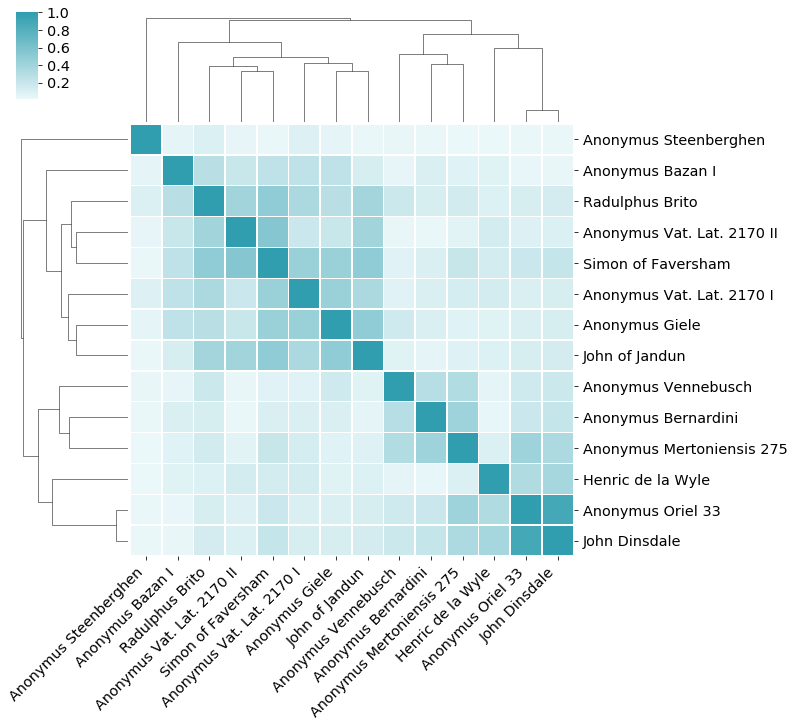

In [55]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [56]:
plot.savefig('../thesis/data/figures/science-positive-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-positive-proportional-clustermap', plot,
    caption='Proportional clustermap of positive doctrines.',
    label='fig:sci:positive:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-positive-proportional-clustermap.pdf}
\caption{Proportional clustermap of positive doctrines.}
\label{fig:sci:positive:prop-clustermap}
\end{figure}


In [57]:
# Mean commonality values 
df.mean().sort_values(ascending=False).round(1)

Simon of Faversham            0.3
Radulphus Brito               0.3
John Dinsdale                 0.3
John of Jandun                0.3
Anonymus Giele                0.3
Anonymus Vat. Lat. 2170 I     0.3
Anonymus Oriel 33             0.3
Anonymus Vat. Lat. 2170 II    0.2
Anonymus Mertoniensis 275     0.2
Anonymus Bernardini           0.2
Anonymus Bazan I              0.2
Henric de la Wyle             0.2
Anonymus Vennebusch           0.2
Anonymus Steenberghen         0.1
dtype: float64

In [58]:
# Dinsdale example
dins = df['John Dinsdale'].round(decimals=2)
save_table('../thesis/data/tables/dinsdale-fingerprint-positive.tex', dins.to_latex(), 
           caption='Example of proportional shared profile for positive doctrines of John Dinsdale.',
           label='tab:sci:determ:profile-dinsdale')
dins

Anonymus Bazan I              0.03
Anonymus Bernardini           0.22
Anonymus Giele                0.12
Anonymus Mertoniensis 275     0.35
Anonymus Oriel 33             0.89
Anonymus Steenberghen         0.02
Anonymus Vat. Lat. 2170 I     0.12
Anonymus Vat. Lat. 2170 II    0.10
Anonymus Vennebusch           0.19
Henric de la Wyle             0.38
John Dinsdale                 1.00
John of Jandun                0.14
Radulphus Brito               0.14
Simon of Faversham            0.22
Name: John Dinsdale, dtype: float64

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

In [59]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author)--(t:Text)--(q:Question)--(d:Doctrine)"
         "WHERE a.name = '%s'"
         "AND NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND (d)-[:SUPPORTS|:USES]-()"
         "RETURN d.name" % name )
    return [t[0] for t in run_query(q).values()]

# Example test
determination_doctrines_of("Anonymus Giele")

['There can be a science of the soul', 'Substantial knowledge from accidents']

Then we create a full list of all the doctrines in determinations.

In [60]:
def all_determination_doctrines():
    q = ("MATCH (d:Doctrine)--(:Question)"
         "WHERE NOT (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
         "AND (d)-[:SUPPORTS|:USES]-()"
         "AND NOT d.name = 'There can be a science of the soul'"
         "RETURN distinct d.name ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_determination_doctrines()

# Test output
all_docs

['Certain science about simple subject',
 'Different types of intelligibility',
 'Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)',
 'Identity of knower and known',
 'Intellect is not like senses but has reflexivity',
 'Propter quod unumquodque tale et illud magis',
 'Science about a substance which contains parts and properties',
 'Science from observations of accidents is also science',
 'Science of form and perfection',
 'Science through self-reflection',
 'Science through subject, properties, principles',
 'Soul has parts and properties in virtue of its embodied activities',
 'Soul indirectly available to sense perception',
 'Substantial knowledge from accidents',
 'There can be science about everything with intelligible essence or definition',
 'Three meanings of science']

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [61]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


df = pd.DataFrame(matrix, index=all_docs)

Okay, I want to sort the matrix by how many doctrines the texts contain. This means that we sort the columns based on the sum of the values. Oddly enough I can't figure out how to do that within the `DataFrame`, so instead I create a dict, from that a list of the authors sorted by their sum doctrines. That list is used for keys in building a new matrix with the desired order. But then the rows and columns are switched, so I need to transmute those with the `zip` function. *This just doesn't feel right*.

In [62]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = determination_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

,Anonymus Bernardini,Anonymus Mertoniensis 275,Anonymus Vennebusch,Anonymus Steenberghen,Anonymus Vat. Lat. 2170 I,Henric de la Wyle,Radulphus Brito,Simon of Faversham,Anonymus Bazan I,Anonymus Oriel 33,John Dinsdale,John of Jandun,Anonymus Vat. Lat. 2170 II,Anonymus Giele
Certain science about simple subject,x,,,,,,,,,,,,,
Different types of intelligibility,x,x,x,,,,,,,,,,,
"Four requirements of a science (universal, incorruptible, parts and properties, intellectual immediacy)",,,,x,,,,,,,,,,
Identity of knower and known,x,x,,,,,,,,,,,,
Intellect is not like senses but has reflexivity,,x,,,,,,,,,,,,
Propter quod unumquodque tale et illud magis,,x,x,,,,,,,,,,,
Science about a substance which contains parts and properties,,,,x,x,,,,,,,,,
Science from observations of accidents is also science,,x,,,,,,,,,,,,
Science of form and perfection,,,,,,x,,,,,,,,
Science through self-reflection,x,x,,,x,,x,x,x,,,,,


I can sort the sum of the DataFrame like this, but I can't figure out how to sort the columns by that.

In [63]:

df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums

Anonymus Mertoniensis 275     9
Anonymus Vat. Lat. 2170 I     6
Anonymus Bernardini           6
Radulphus Brito               4
Henric de la Wyle             4
Anonymus Vennebusch           4
John Dinsdale                 3
Anonymus Oriel 33             3
Simon of Faversham            3
Anonymus Steenberghen         3
John of Jandun                2
Anonymus Giele                1
Anonymus Vat. Lat. 2170 II    1
Anonymus Bazan I              1
dtype: int64

In [64]:
#print(sums.to_latex())

What is the mean amount of doctrines?

In [65]:
df.sum().mean()

3.5714285714285716

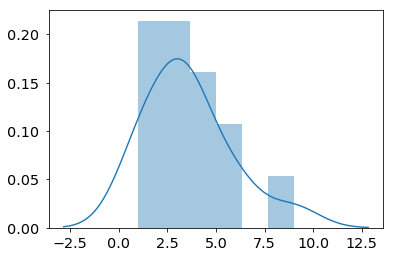

In [66]:
sns.distplot(df.sum())

### Popularity of arguments

In [67]:
df.sum(axis=1).sort_values(ascending=False)

Substantial knowledge from accidents                                                                       10
Science through subject, properties, principles                                                             9
Soul indirectly available to sense perception                                                               6
Science through self-reflection                                                                             6
Different types of intelligibility                                                                          3
Three meanings of science                                                                                   2
Soul has parts and properties in virtue of its embodied activities                                          2
Science about a substance which contains parts and properties                                               2
Propter quod unumquodque tale et illud magis                                                                2
Identity o

# Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

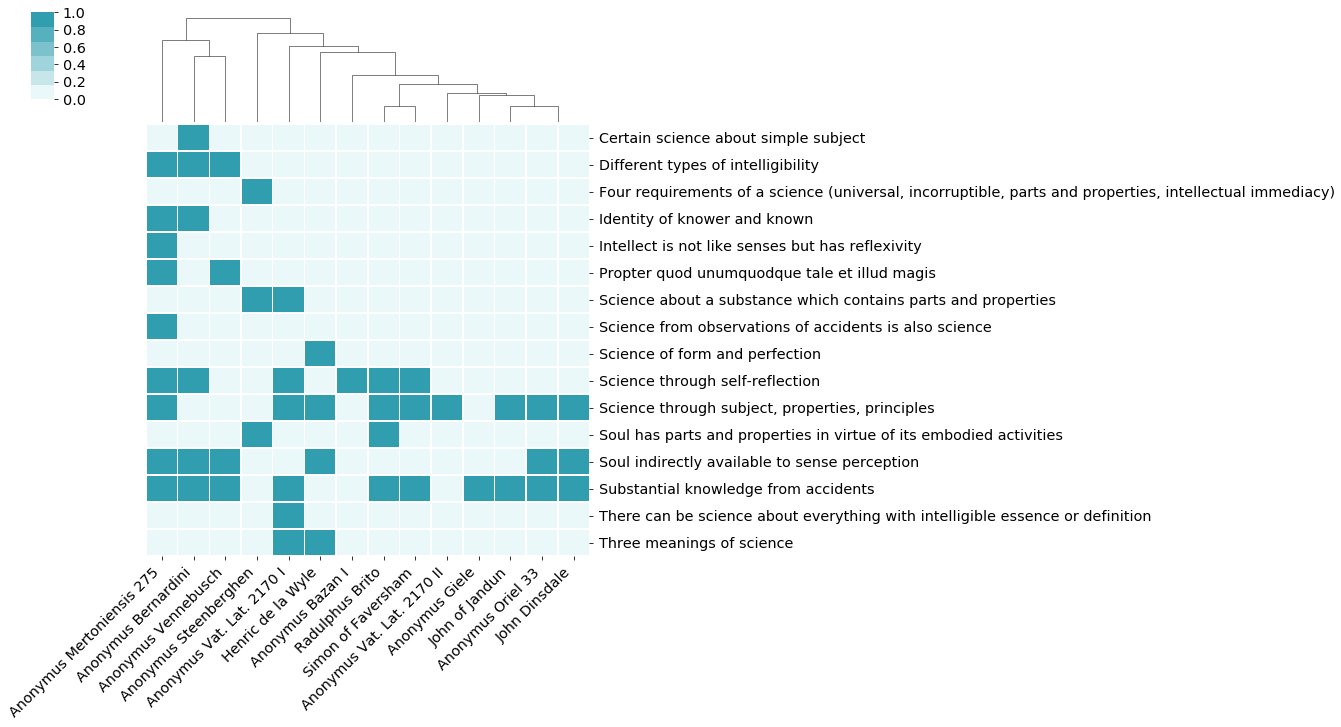

In [68]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=False, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [69]:
plot.savefig('../thesis/data/figures/science-positive-binary-clustermap.pdf')
print_figure_inclusion(
    'science-determinations-binary-clustermap', plot,
    caption='Binary clustermap of positive doctrines.',
    label='fig:sci:positive:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/science-determinations-binary-clustermap.pdf}
\caption{Binary clustermap of positive doctrines.}
\label{fig:sci:positive:binary-clustermap}
\end{figure}


# Doctrines in rationes
How about if we only focus on rationes?

## Proportional representation

First, let's get some simple quantitative data on the amount of doctrines each author has in each category.

In [ ]:
def number_unique_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
                         "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "AND a.name = {name}"
                         "AND NOT (:Question)--(d)--(q:Question)"
                         "RETURN count(distinct d)", name=name)
            return res.single()['count(distinct d)']
            
number_unique_rationes_doctrines('John of Jandun')

In [ ]:
def number_shared_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q:Question)--(d:Doctrine)"
                         "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                         "AND a.name = {name}"
                         "MATCH (q1:Question)--(d)--(q)"
                         "WHERE (q1) <> (q)"
                         "RETURN count(distinct d)", name=name)
            return res.single()['count(distinct d)']

number_shared_rationes_doctrines('John of Jandun')

Proportion unique of all doctrines

In [ ]:
number_unique_rationes_doctrines('John of Jandun') / sum([number_unique_rationes_doctrines('John of Jandun'), 
                                                          number_shared_rationes_doctrines('John of Jandun')])

Now let's get the values of these for all the commentators and put them into a matrix.

In [ ]:
def unique_shared_proportions_all():
    d = {}
    for a in author_names:
        unique = number_unique_rationes_doctrines(a)
        shared = number_shared_rationes_doctrines(a)
        if unique is not 0:
            prop = number_unique_rationes_doctrines(a) / sum([number_unique_rationes_doctrines('John of Jandun'), 
                                                              number_shared_rationes_doctrines('John of Jandun')])
        else:
            prop = 0

        d[a] = [unique, shared, unique + shared, round(prop, 2)]

    return d
m = unique_shared_proportions_all()


Put this in a DataFrame and sort according to most unique.

In [ ]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Sum', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].apply(np.int64)
df

In [ ]:
# Some saving could be set up here...
save_table('../thesis/data/tables/sci-rationes-quantities.tex', df.to_latex(), 
           caption='Unique, shared, total, and proportion of unique to shared doctrines in rationes.',
           label='tab:sci:rationes:quantities')

In [ ]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

In [ ]:
# Number of distinct rationes
rationes_count = run_query('MATCH (d:Doctrine)'
                                 "WHERE (d)-[:ATTACKS]->(:Doctrine {name:'There can be a science of the soul'})"
                                 'RETURN count(DISTINCT d)').single()[0]
rationes_count

In [ ]:
# Proportion of unique
df['Unique'].sum() / rationes_count

In [ ]:
# Proportion of unique instances
df['Unique'].sum() / df['Sum'].sum()

In [ ]:
# Average use number of non-uniques
round(df['Sum'].sum() / (rationes_count - df['Unique'].sum()), 1)

But the relative proportions in relation to all the others is more interesting...

In [ ]:
def proportion_shared_rationes_doctrines(name):
    with driver.session() as session:
        with session.begin_transaction() as tx:
            res = tx.run("MATCH (a:Author)--(:Text)--(q1:Question)--(d:Doctrine)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d)"
                         "WHERE a.name = {name}"
                         "MATCH (d)--(q2:Question)--(:Text)--(a2:Author)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d1:Doctrine)--(q1)"
                         "MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS *1..5]-(d2:Doctrine)--(q2)"
                         "RETURN a2.name, (toFloat(count(distinct d)) / count(distinct d1)) * (toFloat(count(distinct d)) / count(distinct d2))", name=name)
            return {r[0]: r[1] for r in res}

proportion_shared_rationes_doctrines('John of Jandun')

In [ ]:
d = build_matrix(author_names, docfunc=proportion_shared_rationes_doctrines)

In [ ]:
df = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [ ]:
plot.savefig('../thesis/data/figures/science-rationes-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-rationes-proportional-clustermap', plot,
    caption='Proportional clustermap of rationes doctrines.',
    label='fig:sci:rationes:prop-clustermap')

## Binary doctrines

In [ ]:
# All doctrines except the base statement of the science
def all_rationes_doctrines():
    q = ("MATCH (:Doctrine {name:'There can be a science of the soul'})<-[:ATTACKS]-(d)"
         "RETURN distinct(d.name) ORDER BY d.name asc")
    return [t[0] for t in run_query(q).values()]

all_docs = all_rationes_doctrines()

# Test output
len(all_docs)

In [ ]:
def all_rationes_doctrines_of(name):
    q = ("MATCH (r:Doctrine) WHERE r.name='There can be a science of the soul'"
         "MATCH (r)<-[:ATTACKS]-(d:Doctrine)"
         "MATCH (a:Author)--(t:Text)--(q:Question)--(d)"
         "WHERE a.name = '{name}'"
         "RETURN distinct(d.name)".format(name=name))
    return [t[0] for t in run_query(q).values()]

# Example test
all_rationes_doctrines_of("John of Jandun")

In [ ]:
def create_matrix(numeric=True):
    matrix = {}
    if numeric:
        true_val = 1
        false_val = 0
    else:
        true_val = 'x'
        false_val = ''
        
    for author in author_names:
        matrix[author] = []
        adocs = all_rationes_doctrines_of(author)
        for doc in all_docs:
            if doc in adocs:
                matrix[author].append(true_val)
            else:
                matrix[author].append(false_val)
    sorted_names = sorted(matrix, key=matrix.get, reverse=True)
    m = [matrix[key] for key in sorted_names]
    m = [list(i) for i in zip(*m)]
    return pd.DataFrame(m, columns=sorted_names, index=all_docs)

create_matrix(numeric=False)

And now a bit of quantitative info.

In [ ]:
df = create_matrix(numeric=True)
sums = df.sum().sort_values(ascending=False)
sums
#print(sums.to_latex())

In [ ]:
df.sum().mean()

In [ ]:
sns.distplot(df.sum())

In [3]:
df.sum(axis=1).sort_values(ascending=False)

NameError: name 'df' is not defined

In [4]:
df = create_matrix(numeric=True)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(df, cmap=cmap, linewidths=.5, metric='hamming', 
                      row_cluster=True, figsize=(12,16))

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')
    
plot.savefig('../thesis/data/figures/science-determinations-binary-cluster.png')

NameError: name 'create_matrix' is not defined

In [5]:
plot.savefig('../figures/science-rationes-binary-clustermap.pdf')
print_figure_inclusion(
    '../figures/science-rationes-binary-clustermap', plot,
    caption='Binary clustermap of rationes doctrines.',
    label='fig:sci:rationes:binary-clustermap')

NameError: name 'plot' is not defined